In [1]:
import numpy as np 
import pandas as pd 
import os
import re
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from scipy.stats import norm
import matplotlib.pyplot as plt
import sys

In [2]:
Initial_event = 100001
Final_event = 100011
Nchannel = 1
Xpixels = 232
Ypixels = 124
val_size = 0.25
test_size = 0.05
seed = 8
batch_size = 4

In [3]:
Nevents = Final_event - Initial_event
test_low = np.zeros((Nevents*11, Ypixels, Xpixels))
test_high = np.zeros((Nevents*11, Ypixels, Xpixels))
print("Used memory:", (sys.getsizeof(test_low)+sys.getsizeof(test_high))/1024./1024./1024., "GB")
for energy in np.arange(0,11):
    prefix = "/data01/JUNO_ML/KE_"+str(energy)+".0MeV/csvfile"
    datalist = pd.read_csv(prefix+"/list.csv", header=None)
    print("Processing events with energy at", energy, "MeV")
    for event in np.arange(Initial_event, Final_event):
        if event%1000 == 0:
            print("Processing event:", event)
        low_evt = pd.read_csv(prefix+"/low_res/"+datalist.iat[event,0], delimiter="\t", header=None, names=["ID","x","y","time"])
        high_evt = pd.read_csv(prefix+"/high_res/"+datalist.iat[event,0], delimiter="\t", header=None, names=["ID","x","y","time"])
        for pmtid in np.arange(0,low_evt.shape[0]):
            eventindex = Nevents*energy+event-Initial_event
            test_low[eventindex, low_evt.at[pmtid,"y"], low_evt.at[pmtid,"x"]] = low_evt.at[pmtid,"time"]
            test_high[eventindex, high_evt.at[pmtid,"y"], high_evt.at[pmtid,"x"]] = high_evt.at[pmtid,"time"]

Used memory: 0.04715466499328613 GB
Processing events with energy at 0 MeV
Processing events with energy at 1 MeV
Processing events with energy at 2 MeV
Processing events with energy at 3 MeV
Processing events with energy at 4 MeV
Processing events with energy at 5 MeV
Processing events with energy at 6 MeV
Processing events with energy at 7 MeV
Processing events with energy at 8 MeV
Processing events with energy at 9 MeV
Processing events with energy at 10 MeV


In [4]:
model = load_model("autoencoder.h5")
test_pred = model.predict(test_low)
test_pred = test_pred[:,:,:,0] #Convert the shape from (Nevents,Ypixels,Xpixels,1) to (Nevents,Ypixels,Xpixels)

2023-11-28 17:35:58.748419: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-28 17:35:58.752624: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-28 17:35:58.753137: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-28 17:35:58.754124: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [5]:
''''
fig = plt.figure(1,figsize=(40,20))
      
for i in np.arange(3):
    ax = fig.add_subplot(3,3,i*3+1)
    plt.imshow(test_low[i+100,:,:],origin='upper',vmin=0.,vmax=1.0,cmap="jet")
    plt.colorbar()
    ax = fig.add_subplot(3,3,i*3+2)
    plt.imshow(test_pred[i+100,:,:],origin='upper',vmin=0.,vmax=1.0,cmap="jet")
    plt.colorbar()
    ax = fig.add_subplot(3,3,i*3+3)
    plt.imshow(test_high[i+100,:,:],origin='upper',vmin=0.,vmax=1.0,cmap="jet")
    plt.colorbar()
''''

SyntaxError: EOL while scanning string literal (1428351520.py, line 14)

In [6]:
chisq_low_to_high = (test_low-test_high)**2
chisq_pred_to_high = (test_pred-test_high)**2
temp1 = np.zeros(10)
temp2 = np.zeros(10)
print("====================================================================")
for i in np.arange(0,test_low.shape[0]):
    sum_chisq_low_to_high = np.sum(chisq_low_to_high[i])
    sum_chisq_pred_to_high = np.sum(chisq_pred_to_high[i])
    if i//Nevents==0:
        temp1[i] = sum_chisq_low_to_high
        temp2[i] = sum_chisq_pred_to_high
    print("Event:", i)
    print("Kinetic energy:", i//Nevents, "MeV")
    print("Chi^2 between input and true:", sum_chisq_low_to_high)
    print("Chi^2 between output and true:", sum_chisq_pred_to_high)
    print("Improvement:", (sum_chisq_low_to_high-sum_chisq_pred_to_high)/sum_chisq_low_to_high*100., "(%)")
    print("====================================================================")

Event: 0
Kinetic energy: 0 MeV
Chi^2 between input and true: 10.536631166257019
Chi^2 between output and true: 6.706522748556247
Improvement: 36.35040799346269 (%)
Event: 1
Kinetic energy: 0 MeV
Chi^2 between input and true: 9.516975297888642
Chi^2 between output and true: 5.250243611223336
Improvement: 44.83285448488963 (%)
Event: 2
Kinetic energy: 0 MeV
Chi^2 between input and true: 10.99569502432206
Chi^2 between output and true: 6.726096167560024
Improvement: 38.82973152054369 (%)
Event: 3
Kinetic energy: 0 MeV
Chi^2 between input and true: 8.06609062178708
Chi^2 between output and true: 4.332872476791313
Improvement: 46.28286886477671 (%)
Event: 4
Kinetic energy: 0 MeV
Chi^2 between input and true: 9.82935698434671
Chi^2 between output and true: 6.237648423060739
Improvement: 36.54062587212755 (%)
Event: 5
Kinetic energy: 0 MeV
Chi^2 between input and true: 8.29033474014763
Chi^2 between output and true: 4.385555168509576
Improvement: 47.10038489433202 (%)
Event: 6
Kinetic energy:

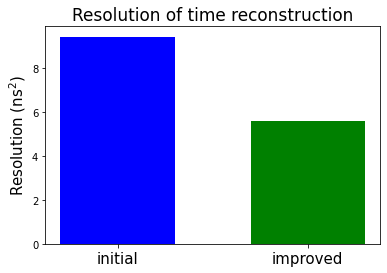

<Figure size 704x396 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [7]:
x = [1,2]
y = [np.sum(temp1)/10., np.sum(temp2)/10.]
dpi = 100
color=["blue","green"]
label = ["initial", "improved"]
plt.bar(x,y,color=color,tick_label=label,width = 0.6)
plt.title("Resolution of time reconstruction",fontsize=17)
plt.xticks(fontsize=15)
plt.ylabel("Resolution (ns$^{2}$)",fontsize=15)
plt.figure(figsize=(704/dpi, 396/dpi),dpi=dpi)
fig1=plt.gcf()
plt.show()
plt.draw()
fig1.savefig('./my_plot.jpg')

In [ ]:
shift = 280
normalization = 1800.+shift
test_low_ns = test_low*normalization
test_pred_ns = test_pred*normalization
test_high_ns = test_high*normalization
test_high_ns[test_high_ns!=0] -= shift

In [ ]:
''''
diff = (test_low_ns[0]-test_high_ns[0]).flatten()
hist = plt.hist(diff[diff!=0], range=(-500,750), bins=1250, density=True)
bin_centers = (hist[1][:-1]+hist[1][1:])/2
mu, sigma = norm.fit(diff[diff>200])
pdf = norm.pdf(bin_centers, mu, sigma)
plt.plot(bin_centers, pdf, 'r-', label='Gaussian Fit')
plt.title("Time diffenece between input and truth")
plt.xlabel("Time diffenece (ns)")
plt.ylabel("Entries")
plt.show()
print("Input sigma =", sigma)
''''

In [ ]:
''''
diff2 = (test_pred_ns[100]-test_high_ns[100])
hist2 = plt.hist(diff2[diff2!=0], range=(-500,750), bins=1250, density=True)
mu2, sigma2 = norm.fit(diff2[diff2>200])
pdf2 = norm.pdf(bin_centers, mu2, sigma2)
plt.plot(bin_centers, pdf2, 'r-', label='Gaussian Fit')
plt.title("Time diffenece between output and truth")
plt.xlabel("Time diffenece (ns)")
plt.ylabel("Entries")
plt.show()
print("Output sigma =", sigma2)
''''